In [ ]:
import skimage
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
import lib

2024-11-27 11:11:13.754518: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 11:11:13.755015: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 11:11:13.757452: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 11:11:13.765913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732702273.780082   47077 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732702273.78

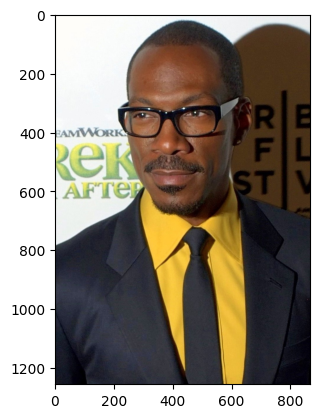

In [3]:
eddie = skimage.io.imread("eddie hi-res.png")[:,:,:3]
plt.imshow(eddie)

# Convertir eddie en Lab
# Séparer L et ab
# "Discrétiser" ab avec des blocs de taille 10

In [4]:
eddie_Lab = skimage.color.rgb2lab(eddie)
eddie_L = eddie_Lab[:,:,0]
eddie_ab = eddie_Lab[:,:,1:]

In [5]:
eddie_ab[0,0]

array([-0.36596866,  2.02988601])

In [6]:
eddie_ab_quantized = (eddie_ab//10)*10 + 5
eddie_ab_quantized

array([[[-5.,  5.],
        [-5.,  5.],
        [-5.,  5.],
        ...,
        [ 5., -5.],
        [ 5., -5.],
        [ 5., -5.]],

       [[-5.,  5.],
        [-5.,  5.],
        [-5.,  5.],
        ...,
        [ 5., -5.],
        [ 5., -5.],
        [ 5., -5.]],

       [[-5.,  5.],
        [-5.,  5.],
        [-5.,  5.],
        ...,
        [ 5., -5.],
        [ 5., -5.],
        [ 5., -5.]],

       ...,

       [[ 5., -5.],
        [ 5., -5.],
        [ 5., -5.],
        ...,
        [ 5., -5.],
        [ 5., -5.],
        [ 5.,  5.]],

       [[ 5., -5.],
        [ 5., -5.],
        [ 5., -5.],
        ...,
        [ 5., -5.],
        [ 5., -5.],
        [ 5.,  5.]],

       [[ 5., -5.],
        [ 5., -5.],
        [ 5., -5.],
        ...,
        [ 5., -5.],
        [ 5., -5.],
        [ 5.,  5.]]])

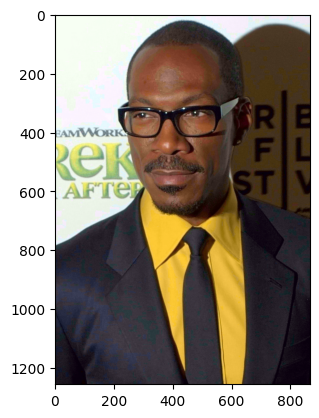

In [7]:
plt.imshow(skimage.color.lab2rgb(np.stack([eddie_L, eddie_ab_quantized[:,:,0], eddie_ab_quantized[:,:,1]], axis=2)))

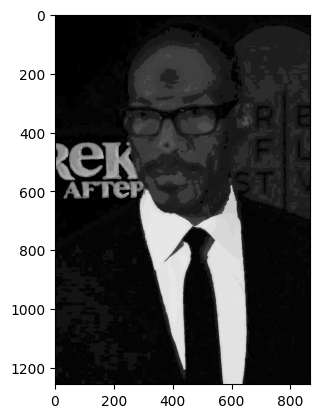

In [8]:
ab_to_label_dict = {}
label_to_ab_dict = {}
last_label = 0

def ab_pixel_to_label(ab_pixel):
    global last_label
    ab_tuple = (ab_pixel[0], ab_pixel[1])
    if ab_tuple not in ab_to_label_dict.keys():
        ab_to_label_dict[ab_tuple] = last_label
        label_to_ab_dict[last_label] = ab_pixel
        last_label += 1
    return ab_to_label_dict[ab_tuple]

def label_to_ab_pixel(label):
    return label_to_ab_dict[label]

def ab_image_to_label(image):
    return np.apply_along_axis(ab_pixel_to_label, axis=2, arr=image)

def label_image_to_ab(image):
    return np.apply_along_axis(label_to_ab_pixel, axis=2, arr=image)

plt.imshow(ab_image_to_label(eddie_ab_quantized), cmap="gray")

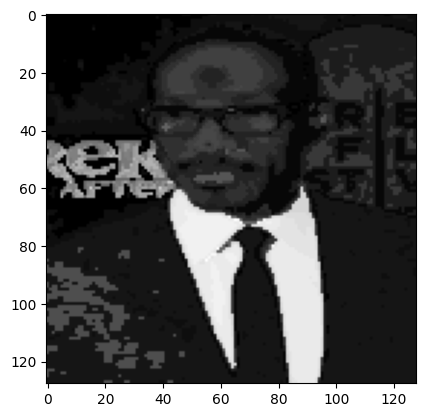

In [9]:
eddie_ab_quantized_squeeze = (skimage.transform.resize((skimage.transform.resize(eddie_ab, (128, 128))//10)*10 + 5, eddie_ab_quantized.shape)//10)*10 +5
plt.imshow(ab_image_to_label(skimage.transform.resize(eddie_ab, (128, 128))//10)*10 + 5, cmap="gray")

In [10]:
def rassembler_L_et_ab(L, ab):
    a = ab[:,:,0]
    b = ab[:,:,1]
    return skimage.color.lab2rgb(np.stack([L, a, b], axis=2))

def reconstituer_image(L, labeled_image):
    return rassembler_L_et_ab(L, label_image_to_ab(labeled_image))

/tmp/ipykernel_47077/3792249955.py:4: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  return skimage.color.lab2rgb(np.stack([L, a, b], axis=2))


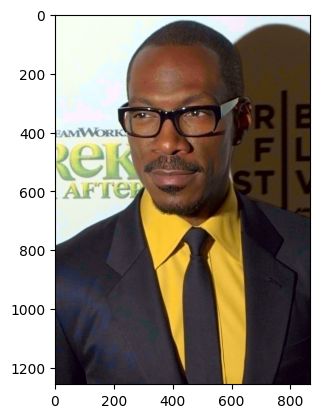

In [11]:
plt.imshow(rassembler_L_et_ab(eddie_L, eddie_ab_quantized_squeeze))

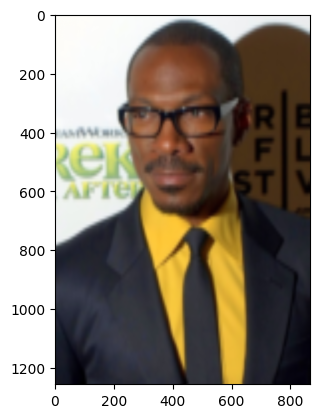

In [12]:
plt.imshow(skimage.transform.resize(skimage.transform.resize(eddie, (128, 128)), eddie.shape))

In [13]:
dataset = keras.utils.image_dataset_from_directory("my_celebs", labels=None, )

Found 33062 files.


2024-11-27 11:11:19.685399: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
